## Import libraries

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [ ]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017.csv')

In [ ]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3,2,0,12,0,6,6,6.0,0.00000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,109,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,52,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,34,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,3,2,0,12,0,6,6,6.0,0.00000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,32215,4,2,112,152,28,28,28.0,0.00000,76,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,324,2,2,84,362,42,42,42.0,0.00000,181,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,82,2,1,31,6,31,0,15.5,21.92031,6,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,1048635,6,2,192,256,32,32,32.0,0.00000,128,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df.Label.value_counts()

BENIGN          2273097
DoS              380699
PortScan         158930
BruteForce        13835
WebAttack          2180
Bot                1966
Infiltration         36
Name: Label, dtype: int64

### Preprocessing (normalization and padding values)

In [ ]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

C:\Users\41364\AppData\Roaming\Python\Python35\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)


### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [ ]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [ ]:
df.Label.value_counts()

0    2273097
3     380699
5     158930
2      13835
6       2180
1       1966
4         36
Name: Label, dtype: int64

In [ ]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [ ]:
X = df_major.drop(['Label'],axis=1)
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [ ]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [ ]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [ ]:
df_major['klabel'].value_counts()

318    22146
2      20340
258    20225
308    18461
432    18154
       ...  
366       70
92        21
596       14
756       10
295        3
Name: klabel, Length: 997, dtype: int64

In [ ]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [ ]:
df_major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.439347,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,391,0
1,-0.439344,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,498,0
2,-0.439345,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,499,0
3,-0.439346,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,787,0
4,-0.439347,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,391,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,-0.438390,-0.007151,-0.008416,-0.043758,-0.007075,-0.250424,0.153902,-0.162296,-0.245069,-0.408376,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,813,0
2830739,-0.439337,-0.009819,-0.008416,-0.046560,-0.006982,-0.230903,0.385923,-0.087065,-0.245069,-0.354429,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,916,0
2830740,-0.439344,-0.009819,-0.009418,-0.051863,-0.007139,-0.246240,-0.310140,-0.229468,-0.167112,-0.444340,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,267,0
2830741,-0.408187,-0.004484,-0.008416,-0.035753,-0.007029,-0.244846,0.220194,-0.140802,-0.245069,-0.381659,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,634,0


In [ ]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [ ]:
result['Label'].value_counts()

0    18185
3     3029
5     1280
2      118
Name: Label, dtype: int64

In [ ]:
result

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
6980,-0.437857,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
1506627,-0.438252,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
1377524,-0.438860,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
2056871,-0.435684,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
2005567,-0.437738,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031173,-0.438439,-0.011153,-0.009418,-0.050963,-0.007110,-0.233691,0.352777,-0.097812,-0.245069,-0.410431,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,999,0
1608048,-0.438422,-0.009819,-0.008416,-0.047160,-0.007083,-0.235086,0.336204,-0.103186,-0.245069,-0.413000,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,999,0
817023,-0.437935,-0.011153,-0.009418,-0.050863,-0.007108,-0.232297,0.369350,-0.092438,-0.245069,-0.408376,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,999,0
559006,-0.437946,-0.011153,-0.009418,-0.050763,-0.007111,-0.230903,0.385923,-0.087065,-0.245069,-0.411459,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,999,0


In [ ]:
result = result.drop(['klabel'],axis=1)
result = result.append(df_minor)

In [ ]:
result.to_csv('./data/CICIDS2017_sample_km.csv',index=0)

### split train set and test set

In [9]:
# Read the sampled dataset
df=pd.read_csv('/content/CICIDS2017_sample_km.csv')

In [10]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [11]:
import numpy as np

print(np.isnan(y).sum())  # Count NaN values in y


0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [13]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [14]:
features = df.dtypes[df.dtypes != 'object'].index

In [15]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [16]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break

In [17]:
X_fs = df[fs].values

In [18]:
X_fs.shape

(26800, 44)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [29]:
!pip install qFS==0.0.2

In [20]:
from qFS import qFS, qFSK, qFSiP, get_i
qfs = qFSK(k = 20)
#fcbf.fit(X_fs, y)

In [21]:
X_fss = qfs.fit_transform(X_fs,y)

In [22]:
X_fss.shape

(26800, 20)

### Re-split train & test sets after feature selection

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [24]:
X_train.shape

(21440, 20)

In [25]:
pd.Series(y_train).value_counts()

,count
0,14580
3,2433
6,1744
1,1573
5,1004
2,77
4,29


### SMOTE to solve class-imbalance

In [26]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={2:1000,4:1000})

In [27]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [28]:
pd.Series(y_train).value_counts()

,count
0,14580
3,2433
6,1744
1,1573
5,1004
4,1000
2,1000


## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9901119402985075
Precision of XGBoost: 0.9901950021260832
Recall of XGBoost: 0.9901119402985075
F1-score of XGBoost: 0.9900980949708591
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3645
           1       0.99      0.98      0.98       393
           2       1.00      1.00      1.00        19
           3       0.99      0.98      0.99       609
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99       251
           6       0.96      0.99      0.98       436

    accuracy                           0.99      5360
   macro avg       0.99      0.95      0.97      5360
weighted avg       0.99      0.99      0.99      5360



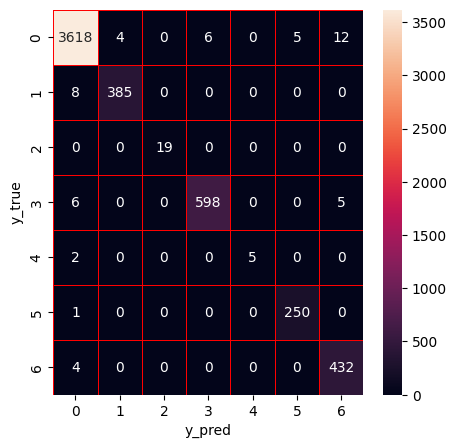

In [29]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [34]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.8 MB/s eta 0:00:00


In [35]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb

# Common function to train, evaluate and plot heatmap
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_predict)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted')

    print(f'Accuracy of {model_name}: {accuracy}')
    print(f'Precision of {model_name}: {precision}')
    print(f'Recall of {model_name}: {recall}')
    print(f'F1-score of {model_name}: {fscore}')
    print(classification_report(y_test, y_predict))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f")
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.title(f"Confusion Matrix of {model_name}")
    plt.show()

# Optuna tuning functions
def tune_dt(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }
    model = DecisionTreeClassifier(**params, random_state=0)
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

def tune_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }
    model = RandomForestClassifier(**params, random_state=0)
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

def tune_et(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }
    model = ExtraTreesClassifier(**params, random_state=0)
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

def tune_xg(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBClassifier(**params, random_state=0)
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

# Running Optuna
def run_optuna(tune_func, model_name, n_trials=50):
    study = optuna.create_study(direction='maximize')
    study.optimize(tune_func, n_trials=n_trials)
    print(f"Best parameters for {model_name}: {study.best_params}")
    return study.best_params


[I 2025-04-03 12:03:29,520] A new study created in memory with name: no-name-c06b86cb-e372-49f1-aff3-2610a0751efc
[I 2025-04-03 12:03:32,549] Trial 0 finished with value: 0.9932835820895523 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.014863164047130471, 'subsample': 0.7198914539712375, 'colsample_bytree': 0.8713603637667938}. Best is trial 0 with value: 0.9932835820895523.
[I 2025-04-03 12:03:35,643] Trial 1 finished with value: 0.9940298507462687 and parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.23676300709741835, 'subsample': 0.7564494829000639, 'colsample_bytree': 0.6559489525135964}. Best is trial 1 with value: 0.9940298507462687.
[I 2025-04-03 12:03:40,088] Trial 2 finished with value: 0.9936567164179104 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.03448029566427085, 'subsample': 0.596693075028473, 'colsample_bytree': 0.5465055212647344}. Best is trial 1 with value: 0.9940298507462687.
[I 2025-04-03 12

Best parameters for XGBoost: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.18701661026329258, 'subsample': 0.7461027811108084, 'colsample_bytree': 0.9993664631688863}
Accuracy of XGBoost: 0.996455223880597
Precision of XGBoost: 0.9964658674507881
Recall of XGBoost: 0.996455223880597
F1-score of XGBoost: 0.9964572109049632
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       609
           4       0.71      0.71      0.71         7
           5       0.99      1.00      0.99       251
           6       1.00      1.00      1.00       436

    accuracy                           1.00      5360
   macro avg       0.95      0.96      0.96      5360
weighted avg       1.00      1.00      1.00      5360



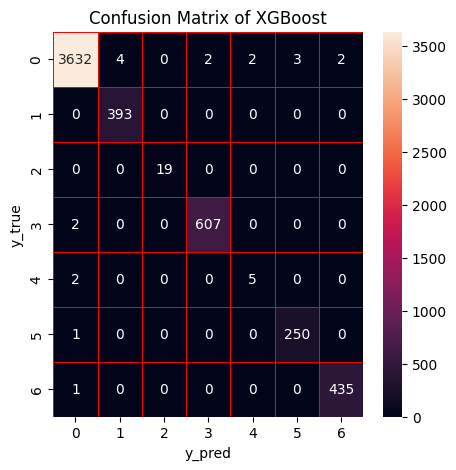

In [36]:
best_xg_params = run_optuna(tune_xg, "XGBoost")
xg = xgb.XGBClassifier(**best_xg_params, random_state=0)
train_and_evaluate(xg, X_train, y_train, X_test, y_test, "XGBoost")

In [37]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.9942164179104478
Precision of RF: 0.9942026410456686
Recall of RF: 0.9942164179104478
F1-score of RF: 0.9941988932298544
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       0.83      0.71      0.77         7
           5       0.99      1.00      0.99       251
           6       0.98      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.97      0.96      0.96      5360
weighted avg       0.99      0.99      0.99      5360



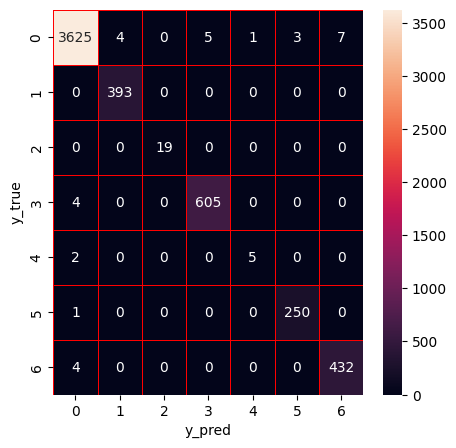

In [38]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

[I 2025-04-03 12:08:01,280] A new study created in memory with name: no-name-66657e5b-8331-4191-909a-ebfc41495718
[I 2025-04-03 12:08:02,611] Trial 0 finished with value: 0.9876865671641791 and parameters: {'n_estimators': 50, 'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 0 with value: 0.9876865671641791.
[I 2025-04-03 12:08:07,778] Trial 1 finished with value: 0.9863805970149254 and parameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 0 with value: 0.9876865671641791.
[I 2025-04-03 12:08:18,130] Trial 2 finished with value: 0.9930970149253732 and parameters: {'n_estimators': 300, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 2 with value: 0.9930970149253732.
[I 2025-04-03 12:08:25,419] Trial 3 finished with value: 0.9850746268656716 and parameters: {'n_estimators': 250, 'max_depth': 12, 'min_sa

Best parameters for Random Forest: {'n_estimators': 100, 'max_depth': 37, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Accuracy of Random Forest: 0.9951492537313433
Precision of Random Forest: 0.9951288591856693
Recall of Random Forest: 0.9951492537313433
F1-score of Random Forest: 0.9951304083134748
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       609
           4       0.83      0.71      0.77         7
           5       0.99      1.00      0.99       251
           6       0.99      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.97      0.96      0.96      5360
weighted avg       1.00      1.00      1.00      5360



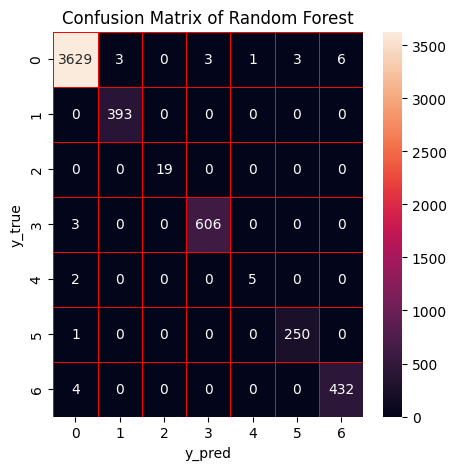

In [39]:

best_rf_params = run_optuna(tune_rf, "Random Forest")
rf = RandomForestClassifier(**best_rf_params, random_state=0)
train_and_evaluate(rf, X_train, y_train, X_test, y_test, "Random Forest")


In [40]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9923507462686567
Precision of DT: 0.9924657440015774
Recall of DT: 0.9923507462686567
F1-score of DT: 0.9923919885633216
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       0.62      0.71      0.67         7
           5       0.98      1.00      0.99       251
           6       0.97      0.99      0.98       436

    accuracy                           0.99      5360
   macro avg       0.94      0.95      0.94      5360
weighted avg       0.99      0.99      0.99      5360



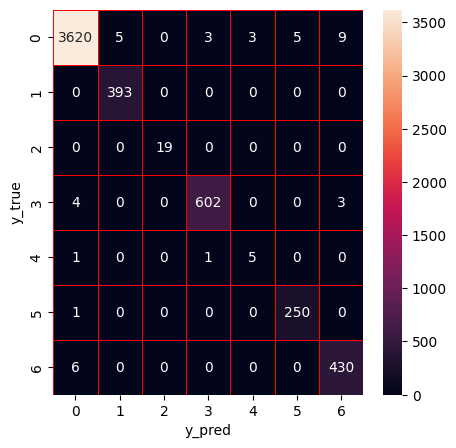

In [41]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

[I 2025-04-03 12:12:28,148] A new study created in memory with name: no-name-0d0622c8-7447-4545-a2a7-54a83739a326
[I 2025-04-03 12:12:28,333] Trial 0 finished with value: 0.9835820895522388 and parameters: {'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 0 with value: 0.9835820895522388.
[I 2025-04-03 12:12:28,498] Trial 1 finished with value: 0.976679104477612 and parameters: {'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9835820895522388.
[I 2025-04-03 12:12:28,670] Trial 2 finished with value: 0.9873134328358208 and parameters: {'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 2 with value: 0.9873134328358208.
[I 2025-04-03 12:12:28,848] Trial 3 finished with value: 0.9888059701492538 and parameters: {'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 3 w

Best parameters for Decision Tree: {'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 1, 'criterion': 'gini'}
Accuracy of Decision Tree: 0.9929104477611941
Precision of Decision Tree: 0.9931027140925083
Recall of Decision Tree: 0.9929104477611941
F1-score of Decision Tree: 0.9929853224384609
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       0.56      0.71      0.62         7
           5       0.98      1.00      0.99       251
           6       0.99      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.93      0.95      0.94      5360
weighted avg       0.99      0.99      0.99      5360



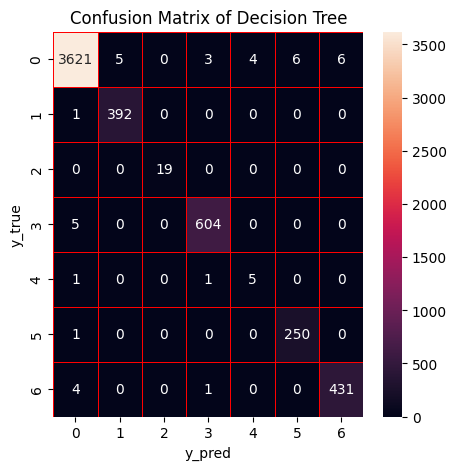

In [42]:

# Tune and Train Models
best_dt_params = run_optuna(tune_dt, "Decision Tree")
dt = DecisionTreeClassifier(**best_dt_params, random_state=0)
train_and_evaluate(dt, X_train, y_train, X_test, y_test, "Decision Tree")


In [43]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9955223880597015
Precision of ET: 0.9954985800463402
Recall of ET: 0.9955223880597015
F1-score of ET: 0.9955023299671734
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       0.83      0.71      0.77         7
           5       0.99      1.00      0.99       251
           6       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.97      0.96      0.96      5360
weighted avg       1.00      1.00      1.00      5360



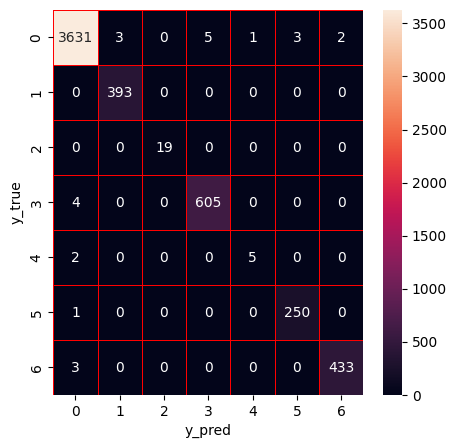

In [44]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

[I 2025-04-03 12:12:40,540] A new study created in memory with name: no-name-de7270ce-67d3-41a2-99b5-cc71f00c7f08
[I 2025-04-03 12:12:41,395] Trial 0 finished with value: 0.9634328358208956 and parameters: {'n_estimators': 50, 'max_depth': 34, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9634328358208956.
[I 2025-04-03 12:12:42,824] Trial 1 finished with value: 0.8180970149253731 and parameters: {'n_estimators': 150, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9634328358208956.
[I 2025-04-03 12:12:43,427] Trial 2 finished with value: 0.9022388059701493 and parameters: {'n_estimators': 50, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9634328358208956.
[I 2025-04-03 12:12:45,593] Trial 3 finished with value: 0.9585820895522388 and parameters: {'n_estimators': 200, 'max_depth': 25, 'm

Best parameters for Extra Trees: {'n_estimators': 300, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Accuracy of Extra Trees: 0.9953358208955224
Precision of Extra Trees: 0.9953115102979498
Recall of Extra Trees: 0.9953358208955224
F1-score of Extra Trees: 0.9953152806273606
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       0.83      0.71      0.77         7
           5       0.99      1.00      0.99       251
           6       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.97      0.96      0.96      5360
weighted avg       1.00      1.00      1.00      5360



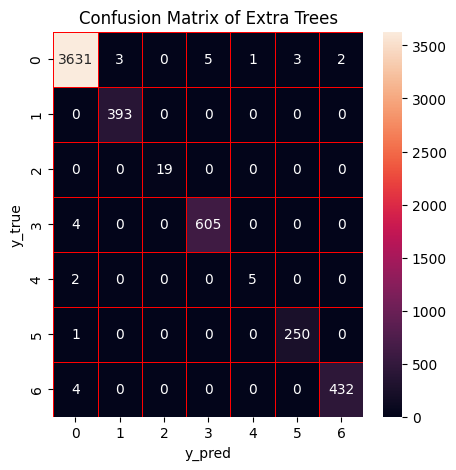

In [45]:
best_et_params = run_optuna(tune_et, "Extra Trees")
et = ExtraTreesClassifier(**best_et_params, random_state=0)
train_and_evaluate(et, X_train, y_train, X_test, y_test, "Extra Trees")



In [46]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [47]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,0,0,0,0
1,0,0,0,0
2,1,1,1,1
3,0,0,0,0
4,3,3,3,3


In [48]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [49]:
dt_train.shape

(23334, 1)

In [50]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9953358208955224
Precision of Stacking: 0.9953115102979498
Recall of Stacking: 0.9953358208955224
F1-score of Stacking: 0.9953152806273606
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       0.83      0.71      0.77         7
           5       0.99      1.00      0.99       251
           6       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.97      0.96      0.96      5360
weighted avg       1.00      1.00      1.00      5360



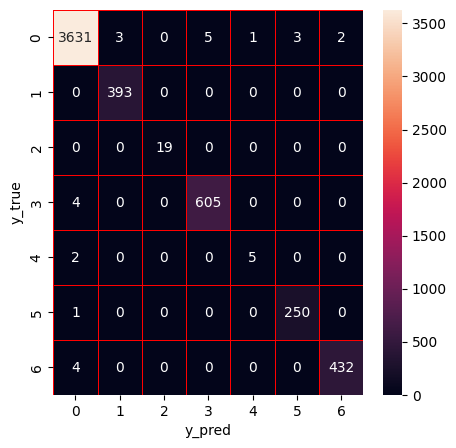

In [51]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

[I 2025-04-03 12:15:13,261] A new study created in memory with name: no-name-5a3efa1b-e613-4252-a0b0-d4c6be0995a7
[I 2025-04-03 12:15:16,429] Trial 0 finished with value: 0.9940298507462687 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01993275063494626, 'subsample': 0.8216141317201272, 'colsample_bytree': 0.816731473634333}. Best is trial 0 with value: 0.9940298507462687.
[I 2025-04-03 12:15:17,722] Trial 1 finished with value: 0.9942164179104478 and parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.06878709567384617, 'subsample': 0.6158704612245756, 'colsample_bytree': 0.7817302372210511}. Best is trial 1 with value: 0.9942164179104478.
[I 2025-04-03 12:15:24,735] Trial 2 finished with value: 0.9958955223880597 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.07098099601039731, 'subsample': 0.5418878540807294, 'colsample_bytree': 0.8467430671320708}. Best is trial 2 with value: 0.9958955223880597.
[I 2025-04-03 12

Best parameters for XGBoost: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.24821209649336703, 'subsample': 0.8972081689986322, 'colsample_bytree': 0.9348828138531887}
Accuracy of XGBoost: 0.9953358208955224
Precision of XGBoost: 0.9953115102979498
Recall of XGBoost: 0.9953358208955224
F1-score of XGBoost: 0.9953152806273606
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       0.83      0.71      0.77         7
           5       0.99      1.00      0.99       251
           6       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.97      0.96      0.96      5360
weighted avg       1.00      1.00      1.00      5360



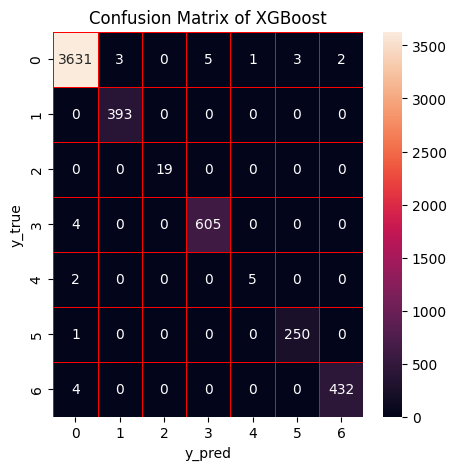

In [52]:
best_xg_params = run_optuna(tune_xg, "XGBoost")
xg = xgb.XGBClassifier(**best_xg_params, random_state=0)
train_and_evaluate(xg, x_train, y_train, x_test, y_test, "XGBoost")

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [10]:
df=pd.read_csv('/kaggle/input/cicids2017-sample-km/CICIDS2017_sample_km.csv')

In [11]:
df.Label.value_counts()

Label
0    18225
3     3042
6     2180
1     1966
5     1255
2       96
4       36
Name: count, dtype: int64

In [12]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('CICIDS2017_sample_km_without_portscan.csv',index=0)

In [13]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('CICIDS2017_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [14]:
df1 = pd.read_csv('CICIDS2017_sample_km_without_portscan.csv')
df2 = pd.read_csv('CICIDS2017_sample_km_portscan.csv')

In [15]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [16]:
df1.Label.value_counts()

Label
0    18225
1     7320
Name: count, dtype: int64

In [17]:
df2.Label.value_counts()

Label
1    1255
Name: count, dtype: int64

In [18]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [19]:
df2.Label.value_counts()

Label
1    1255
0    1255
Name: count, dtype: int64

In [20]:
df = pd.concat([df1, df2], ignore_index=True)


In [21]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

0    19480
1     8575
Name: count, dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [22]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [23]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [24]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break

In [25]:
X_fs = df[fs].values

In [26]:
X_fs.shape

(28055, 50)

In [27]:
X_fs

array([[-0.34612159, -0.51326791, -0.27787307, ..., -0.13353417,
        -0.09211243, -0.05349902],
       [-0.3443274 , -0.51326791, -0.27787307, ..., -0.13353417,
        -0.09211243, -0.05349902],
       [-0.3443274 , -0.51326791, -0.27787307, ..., -0.13353417,
        -0.09211243, -0.05349902],
       ...,
       [-0.36859622, -0.27885966, -0.27605203, ..., -0.13353417,
        -0.09211243, -0.04188076],
       [-0.35688675, -0.17919471, -0.24290152, ...,  0.34741058,
         0.04306336,  0.09753834],
       [-0.36859622, -0.32264281, -0.27711203, ..., -0.13353417,
        -0.09211243, -0.04188076]])

In [30]:
from qFS import qFS, qFSK, qFSiP, get_i
qfs = qFSK(k = 20)
#fcbf.fit(X_fs, y)

In [31]:
X_fss = qfs.fit_transform(X_fs,y)

In [32]:
X_fss.shape

(28055, 20)

In [33]:
X_fss

array([[-0.34612159, -0.53319222, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.41947688],
       [-0.3443274 , -0.54906516, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.41947688],
       [-0.3443274 , -0.55544206, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.41947688],
       ...,
       [-0.36859622, -0.56375976, -0.34935843, ..., -0.42229756,
        -0.28029987, -0.3499183 ],
       [-0.35688675,  0.00413109,  2.04915832, ...,  3.23750835,
         0.71435728,  0.18659942],
       [-0.36859622, -0.56375976, -0.34935843, ..., -0.42229753,
        -0.28029976, -0.36825157]])

####  kernel principal component analysis (KPCA)

In [34]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [35]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [36]:

pd.Series(y_train).value_counts()

0    18225
1     7320
Name: count, dtype: int64

In [37]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
X_train, y_train = smote.fit_resample(X_train, y_train)

In [38]:
pd.Series(y_train).value_counts()

0    18225
1    18225
Name: count, dtype: int64

In [39]:
pd.Series(y_test).value_counts()

1    1255
0    1255
Name: count, dtype: int64

### Apply the cluster labeling (CL) k-means method

In [40]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [41]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else:
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [42]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.49      0.94      0.64      1255
           1       0.00      0.00      0.00      1255

    accuracy                           0.47      2510
   macro avg       0.24      0.47      0.32      2510
weighted avg       0.24      0.47      0.32      2510

0.4717131474103586
[[1184   71]
 [1255    0]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [43]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']

    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else:
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.3908366533864542
43 0.4103585657370518
43 0.696812749003984
43 0.43904382470119524
32 0.43545816733067727
20 0.6087649402390438
16 0.47250996015936253
5 0.4701195219123506
15 0.45776892430278887
25 0.600796812749004
2 0.42191235059760956
22 0.4366533864541833
19 0.3697211155378486
26 0.4235059760956175
24 0.4063745019920319
42 0.4099601593625498
50 0.4131474103585657
14 0.4709163346613546
15 0.4613545816733068
14 0.4609561752988048
39.25808072090149
Best score=0.6968
Best parameters: n_clusters=43


In [ ]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']),
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']

    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else:
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

36 0.3880478087649402                                 
35 0.6621513944223107                                                           
46 0.4402390438247012                                                            
32 0.4398406374501992                                                            
12 0.700398406374502                                                             
41 0.40358565737051794                                                           
49 0.43864541832669324                                                         
25 0.40199203187251                                                            
42 0.4043824701195219                                                          
40 0.4334661354581673                                                          
18 0.49243027888446217                                                          
48 0.40199203187251                                                             
4 0.3944223107569721                                  

In [ ]:
CL_kmeans(X_train, X_test, y_train, y_test, 16)

### Apply the CL-k-means model with biased classifiers

In [ ]:
# Only a sample code to show the logic. It needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else:
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)

    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))

    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]

    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)

    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])

    Xp = dffp_f.drop(['Label'],axis=1)
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)

    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])

    Xnn = dffn_f.drop(['Label'],axis=1)
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1)
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else:
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)

95% of the code has been shared, and the remaining 5% is retained for future extension.  
Thank you for your interest and more details are in the paper.